In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
%matplotlib inline
%load_ext autoreload
%autoreload 2
# u can use %matplotlib notebook, but there is some bugs with xticks and title

from brainpipe.classification import *
from brainpipe.visual import *
import mne
from mne.viz import plot_topomap
from mne import pick_types, find_layout
# -- Define function that can read info from both fif and ds files -- #
import contextlib

# -- Works both in python2 and python3 -- #
try:
    from cStringIO import StringIO
except ImportError:
    from io import StringIO
# --------------------------------------- #
    
@contextlib.contextmanager
def nostdout():
    save_stdout = sys.stdout
    sys.stdout = StringIO()
    yield
    sys.stdout = save_stdout

def read_info_custom(fname):
    """Read info from .fif or from .ds"""
    from os.path import splitext
    _,ext = splitext(fname)
    if ext == '.fif':
        from mne.io import read_info
        info = read_info(fname)
    elif ext == '.ds':
        from mne.io import read_raw_ctf
        with nostdout():
            raw = read_raw_ctf(fname)
        info = raw.info
    else:
        raise RuntimeError('Unknown format for {}'.format(fname))
    return info

In [2]:
path = '/media/karim/4TB_drive/New_new_Pow_Amp_Sigfilt_analysis/'
Cx = 'beta'
subjects = ['Sub_S2', 'Sub_S3','Sub_S4','Sub_S5','Sub_S6','Sub_S8','Sub_S10']
temp_con = '_conscious_'
temp_uncon = '_unconscious_'

In [3]:
x, y = [], []
for num, k in enumerate(subjects):
    print('Load '+ k + '(' + str(num) +')')

    # Unconscious :
    uncon = sio.loadmat(path + k + temp_uncon  + Cx+ '_power.mat') ['Power']
    uncon = np.mean(uncon,axis=1)[...,np.newaxis]
    # Conscious :   
    con = sio.loadmat(path + k + temp_con  + Cx+ '_power.mat') ['Power']

    #con=np.zeros_like(uncon) 
    #if len(con_temp[1]) < len(uncon[1]):
        #con = con_temp
    #else:
        #for jj in range(len(con)):
            #con[jj,:] = np.random.choice(con_temp[jj],len(uncon[1]),replace=False)

    assert con.shape[0]==uncon.shape[0],"attention, con et uncon pas le même nb d'elec"
    if con.shape[0] == 65:
        elec = np.ones(shape = (con.shape[0]),dtype = bool)
        elec[[39,44]] = False
        con = con[elec,:]
        uncon = uncon[elec,:]
    con = np.mean(con, axis =1)[...,np.newaxis]
    
    print(con.shape)
    print(uncon.shape)
    x.append(np.concatenate((con, uncon), axis=1).T)
    y.append([0]*con.shape[1] + [1]*uncon.shape[1])

Load Sub_S2(0)
(63, 1)
(63, 1)
Load Sub_S3(1)
(63, 1)
(63, 1)
Load Sub_S4(2)
(63, 1)
(63, 1)
Load Sub_S5(3)
(63, 1)
(63, 1)
Load Sub_S6(4)
(63, 1)
(63, 1)
Load Sub_S8(5)
(63, 1)
(63, 1)
Load Sub_S10(6)
(63, 1)
(63, 1)


In [4]:
grp = ['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'E11', 'E12', 'E13', 'E14', 'E15', 'E16',
           'E17', 'E18', 'E19', 'E20', 'E21', 'E22', 'E23', 'E24', 'E25', 'E26', 'E27', 'E28', 'E29', 'E30', 'E31',
           'E32', 'E33', 'E34', 'E35', 'E36', 'E37', 'E38', 'E39', 'E41', 'E42', 'E43', 'E44', 'E46',
           'E47', 'E48', 'E49', 'E50', 'E51', 'E52', 'E53', 'E54', 'E55', 'E56', 'E57', 'E58', 'E59', 'E60', 'E61',
           'E62', 'E63','E64','E65']

In [5]:
filesave = '/home/thomasthiery/Dropbox/Results_MDFA/NEW_Pow_Amp_Brainpipe/Power/classif/mean/'
classifier = '_lda'
# Classification object :
lpso = LeavePSubjectOut(y, 7, pout=1, clf='lda') # Leave ONE-subject out (pout)
defClf
# Run classification :
da, pvalue, daperm = lpso.fit(x, n_perm=128, grp=grp , method='label_rnd')

sio.savemat(filesave+'da_sf_shallow_'+Cx+classifier,{'da_sf_shallow_final': da})
sio.savemat(filesave+'pvalue_sf_shallow_'+Cx+classifier,{'pvalue_sf_shallow_final': pvalue})
sio.savemat(filesave+'da_perm_sf_shallow_'+Cx+classifier,{'da_perm_sf_shallow_final': daperm})

<bound method clfstat.perm_pvalue2da of <brainpipe.clf.utils._classif.clfstat object at 0x7fc1e71367b8>>

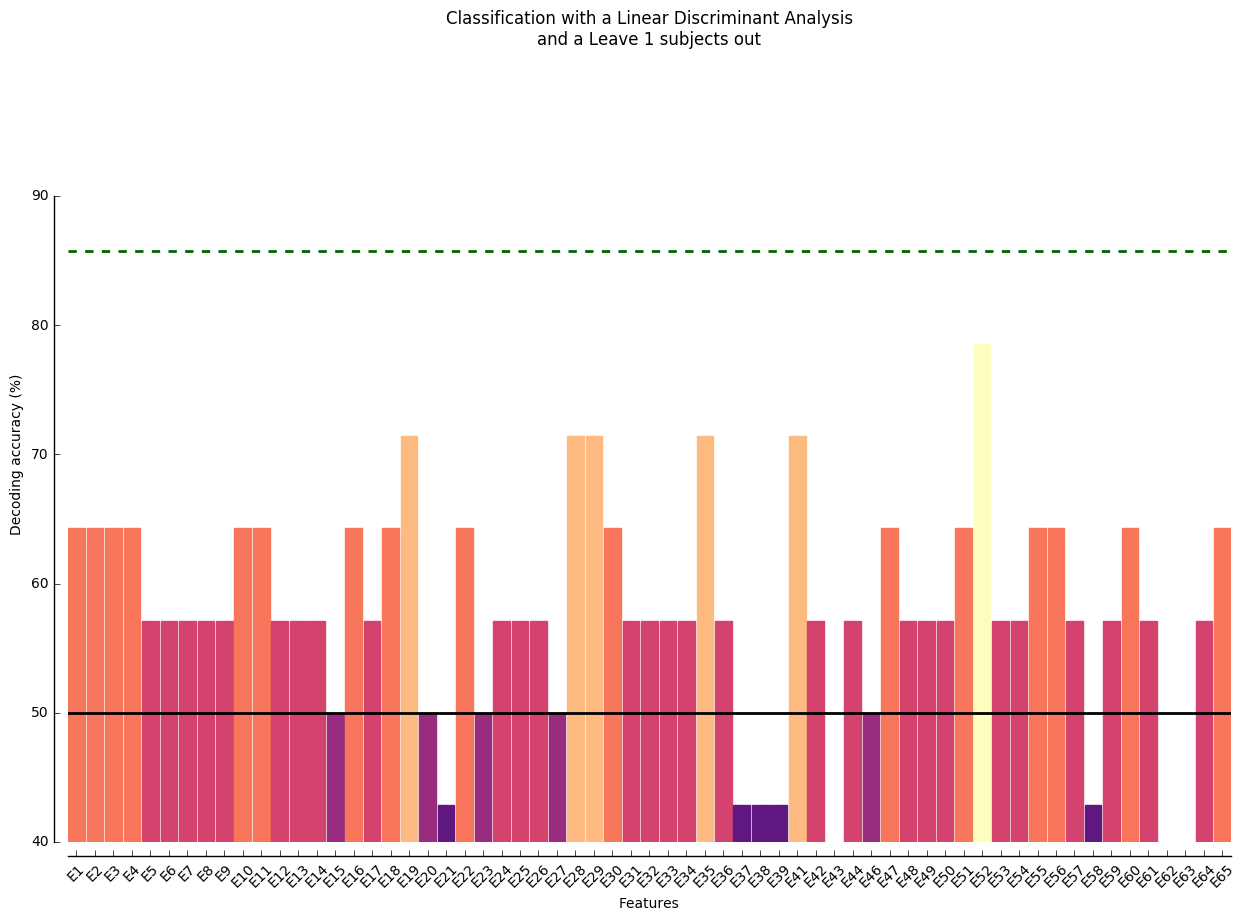

In [6]:
fig = plt.figure(1, figsize=(15,10))

lpso.daplot(da, daperm=daperm, chance_method='perm', rmax=['top', 'right'],
            dpax=['bottom', 'left'], cmap='magma',
            ylim=[40,100], chance_unique=True,chance_level = 0.05,
            chance_color='darkgreen')
plt.savefig(filesave+ Cx +'_sf_shallow_'+classifier+'_005.png', dpi=300)

# Display informations about features :
lpso.info.to_excel(filesave+Cx +'_new_sf_shallow_'+classifier+'_005.xlsx')

lpso.stat.perm_pvalue2da

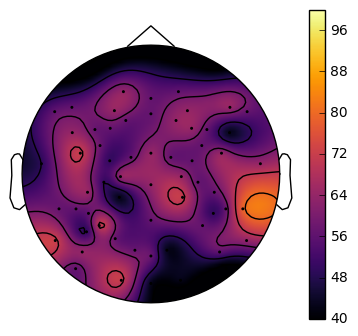

In [ ]:
sensors_pos = sio.loadmat('/home/thomasthiery/Dropbox/Rep_MATLAB/electrodes_sevo_new.mat')['electrodes_sevo_new']

data = sio.loadmat(filesave + 'da_sf_shallow_'+Cx+classifier+'.mat') [ 'da_sf_shallow_final'].T 
data = np.squeeze(data)

mask_default = np.full((len(data)), False, dtype=bool)
mask = np.array(mask_default)
mask[data >np.amax(daperm)] = True
#mask[data >70] = True
#
mask_params = dict(marker='*', markerfacecolor='w', markersize=15) # significant sensors appearence

fig = plt.figure(figsize = (10,15))
plt.subplot(1,2,1)
ax,_ = plot_topomap(data, sensors_pos,
                    cmap='inferno', show=False, vmin=40, vmax=100, mask = mask, mask_params = mask_params)

fig.colorbar(ax, shrink=0.25)
plt.savefig(filesave + 'da_sf_shallow_'+Cx+'_fig_python'+classifier+'005.png', dpi = 300)